# Project-2 Анализ воронки

### Задачи:
**1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.** Насколько обучение сокращает время прохождения этапов?

**2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.** Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.

**3. Дополнительная задача. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?** Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

In [ ]:
#Загрузка библиотек и файлов
import pandas as pd
events = pd.read_csv('7_4_Events.csv')
purch = pd.read_csv('purchase_-_purchase.csv')

### Отбираем пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно)

In [ ]:
# Работаем с датасетом, включающим данные о событиях, которые совершают пользователи.
cond = (events.start_time>='2018-01-01') & (events.start_time<'2019-01-01') & (events.event_type=='registration')
registered = events[cond]['user_id'].to_list() # список пользователей, зарег. в 2018
events18 = events[events.user_id.isin(registered)]
events18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
events18.describe(include = 'all')

,id,event_type,selected_level,start_time,tutorial_id,user_id
count,66959.000000,66959,8342,66959,32954.000000,66959.000000
unique,NaN,5,3,66809,NaN,NaN
top,NaN,registration,medium,2018-03-13T09:37:43,NaN,NaN
freq,NaN,19926,4645,9,NaN,NaN
mean,113787.000045,NaN,NaN,NaN,40532.934393,37781.543362
std,19329.542752,NaN,NaN,NaN,5213.486632,5751.497904
min,80308.000000,NaN,NaN,NaN,31505.000000,27832.000000
25%,97047.500000,NaN,NaN,NaN,36008.250000,32849.000000
50%,113787.000000,NaN,NaN,NaN,40529.500000,37719.000000
75%,130526.500000,NaN,NaN,NaN,45057.750000,42733.000000


In [ ]:
events18.event_type.unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice'], dtype=object)

In [ ]:
events18.selected_level.unique()

array([nan, 'medium', 'hard', 'easy'], dtype=object)

In [ ]:
events18.user_id.nunique()

19926

In [ ]:
# Работаем с датасетом, включающим данные об оплатах, которые совершают пользователи.
purch18 = purch[purch.user_id.isin(registered)]
purch18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1600 non-null   int64 
 1   user_id         1600 non-null   int64 
 2   event_datetime  1600 non-null   object
 3   amount          1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


In [ ]:
purch18.describe()

,id,user_id,amount
count,1600.000000,1600.000000,1600.000000
mean,17645.505625,37752.766250,110.734375
std,462.038637,5822.621784,54.696628
min,16845.000000,27845.000000,25.000000
25%,17245.750000,32815.750000,50.000000
50%,17645.500000,37633.500000,100.000000
75%,18045.250000,43023.000000,150.000000
max,18452.000000,47742.000000,300.000000


## Гипотеза №1
### Время прохождения различных этапов для пользователей, которые прошли обучение, отличается от пользователей, не начинавших обучение.

In [ ]:
#Сделаем необходимые преобразования

#Переименуем id в датафремах
events18 = events18.rename(columns={'id':'event_id'})
purch18 = purch18.rename(columns={'id':'purchase_id', 'event_datetime':'start_time'})

#Добавим столбец
purch18['event_type'] = 'purchase' 

In [ ]:
#Обединим два датафрема в один
total_events = pd.concat([events18, purch18], sort = False)

#Сброс индексов объединенного датафрейма и сортировка событий по времени (по возрастанию)
total_events = total_events.reset_index(drop = True).sort_values('start_time')

#Преобразование дат к нужному типу
total_events.start_time = pd.to_datetime(total_events.start_time, format = '%Y-%m-%dT%H:%M:%S')

In [ ]:
total_events.head(10)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
8,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaN
9,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaN


In [ ]:
#Создаем таблицу, в которой будет отражено время для каждого события пользователя.
pivot = total_events.pivot_table(values = ['start_time'], index = ['user_id'], columns = ['event_type'], aggfunc = 'min')
pivot.columns=list(map('_'.join,pivot))
pivot = pivot.reset_index()
pivot.head()

,user_id,start_time_level_choice,start_time_pack_choice,start_time_purchase,start_time_registration,start_time_tutorial_finish,start_time_tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


In [ ]:
#Рассчитываем разницу между событиями 
pivot['timedelta_lvl_reg'] = pivot['start_time_level_choice'] - pivot['start_time_registration']
pivot['timedelta_pack_reg'] = pivot['start_time_pack_choice'] - pivot['start_time_registration']
pivot['timedelta_purch_reg'] = pivot['start_time_purchase'] - pivot['start_time_registration']
pivot['timedelta_pack_lvl'] = pivot['start_time_pack_choice'] - pivot['start_time_level_choice']
pivot['timedelta_purch_lvl'] = pivot['start_time_purchase'] - pivot['start_time_level_choice']
pivot['timedelta_purch_pack'] = pivot['start_time_purchase'] - pivot['start_time_pack_choice']

In [ ]:
pivot

,user_id,start_time_level_choice,start_time_pack_choice,start_time_purchase,start_time_registration,start_time_tutorial_finish,start_time_tutorial_start,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT,NaT,NaT,NaT
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT,NaT,NaT,NaT
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 08:42:35,0 days 08:43:56,NaT,0 days 00:01:21,NaT,NaT
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19921,47753,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56,0 days 03:37:24,0 days 03:39:10,NaT,0 days 00:01:46,NaT,NaT
19922,47754,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
19923,47755,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14,0 days 07:49:38,NaT,NaT,NaT,NaT,NaT
19924,47756,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2018-12-31 23:17:30,2019-01-01 03:29:25,2019-01-01 03:26:18,0 days 06:24:41,0 days 06:33:06,NaT,0 days 00:08:25,NaT,NaT


#### Теперь разделим пользователей на 2 группы:

1. Пользователи, прошедшие обучение
2. Пользователи, не начинавшие обучение

In [ ]:
#Пользователи, прошедшие обучение
tut_finished_users = events18[events18['event_type'] == 'tutorial_finish'].user_id.unique()

#Пользователи, не начинавшие обучение
tut_started_users = set(events[events['event_type'] == 'tutorial_start'].user_id)
registered_users = set(events[events['event_type'] == 'registration'].user_id)
tut_not_started_users = registered_users - tut_started_users

In [ ]:
#Получим эти две группы пользователей из таблицы pivot
tut_finished_group = pivot[pivot.user_id.isin(tut_finished_users)]
tut_not_started_group = pivot[pivot.user_id.isin(tut_not_started_users)]

In [ ]:
tut_finished_group = tut_finished_group.reset_index(drop = True)
tut_finished_group.head()

,user_id,start_time_level_choice,start_time_pack_choice,start_time_purchase,start_time_registration,start_time_tutorial_finish,start_time_tutorial_start,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack
0,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT,NaT,NaT,NaT
1,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT,NaT,NaT,NaT
2,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 08:42:35,0 days 08:43:56,NaT,0 days 00:01:21,NaT,NaT
3,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT,NaT,NaT,NaT
4,27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT,2018-01-01 18:24:01,2018-01-01 19:16:32,2018-01-01 19:11:36,0 days 04:13:49,0 days 04:18:53,NaT,0 days 00:05:04,NaT,NaT


In [ ]:
tut_not_started_group = tut_not_started_group.reset_index(drop = True)
tut_not_started_group.head()

,user_id,start_time_level_choice,start_time_pack_choice,start_time_purchase,start_time_registration,start_time_tutorial_finish,start_time_tutorial_start,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,27837,NaT,NaT,NaT,2018-01-01 14:08:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,27838,NaT,NaT,NaT,2018-01-01 14:42:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,27844,NaT,NaT,NaT,2018-01-02 00:13:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,27848,NaT,NaT,NaT,2018-01-02 06:05:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## Визуализация для гипотезы №1

In [ ]:
#Импортируем необходимые библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import warnings; warnings.simplefilter('ignore')

In [ ]:
#Вытаскиваем средние значения
desc1 = tut_not_started_group.describe()
mean1 = desc1[desc1.index == 'mean']
mean1.drop('user_id',axis=1, inplace=True)
mean1 = mean1.transpose()

In [ ]:
#Вычисляем кол-во часов
mean1['mean_float_1'] = mean1['mean'] / pd.Timedelta('1 hour')

In [ ]:
#Транспонируем и добавляем столбец с названием группы (не начинавших обучение)
mean1 = mean1.transpose()
mean1['Group'] = 'Tutorial not started group' 
mean1

,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack,Group
mean,0 days 05:15:33.122448979,0 days 05:07:16.175675675,4 days 09:06:01.909090909,0 days 00:05:23.824324324,4 days 04:54:56.272727272,4 days 04:49:33.590909090,Tutorial not started group
mean_float_1,5.2592,5.12116,105.101,0.0899512,100.916,100.826,Tutorial not started group


In [ ]:
#То же самое для группы, окончивших обучение
desc2 = tut_finished_group.describe()
mean2 = desc2[desc2.index == 'mean']
mean2.drop('user_id',axis=1, inplace=True)
mean2 = mean2.transpose()
mean2['mean_float_2'] = mean2['mean'] / pd.Timedelta('1 hour')
mean2 = mean2.transpose()
mean2['Group'] = 'Finished tutorial group' 
mean2

,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack,Group
mean,0 days 07:05:36.854819357,0 days 07:10:35.660162287,4 days 00:30:03.247408431,0 days 00:05:18.146058732,3 days 17:23:24.954388389,3 days 17:17:59.641326883,Finished tutorial group
mean_float_2,7.09357,7.17657,96.5009,0.0883739,89.3903,89.2999,Finished tutorial group


In [ ]:
#Соединяем две таблицы средних и оставляем только округленные часы
means = pd.concat([mean1, mean2])
means = means.transpose()
means = means[['mean_float_1', 'mean_float_2']]
means = means.transpose()
means

,timedelta_lvl_reg,timedelta_pack_reg,timedelta_purch_reg,timedelta_pack_lvl,timedelta_purch_lvl,timedelta_purch_pack,Group
mean_float_1,5.2592,5.12116,105.101,0.0899512,100.916,100.826,Tutorial not started group
mean_float_2,7.09357,7.17657,96.5009,0.0883739,89.3903,89.2999,Finished tutorial group


Разница во времени между **регистрацией и выбором уровня** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_lvl_reg'>

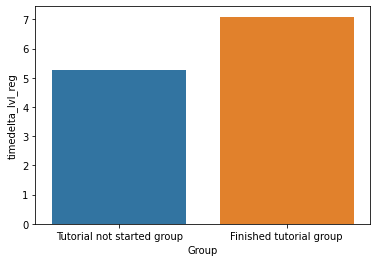

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_lvl_reg', data = means)

Разница во времени между **регистрацией и выбором пакетов игры** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_pack_reg'>

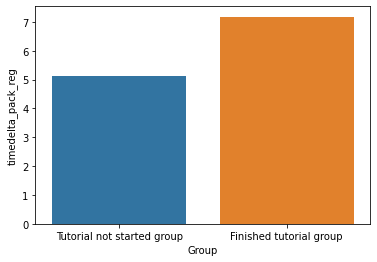

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_pack_reg', data = means)

Разница во времени между **выбором уровня и выбором пакетов игры** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_pack_lvl'>

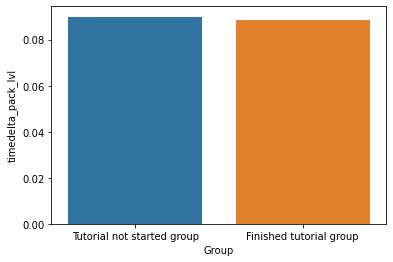

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_pack_lvl', data = means)

Разница во времени между **регистрацией и покупкой** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_purch_reg'>

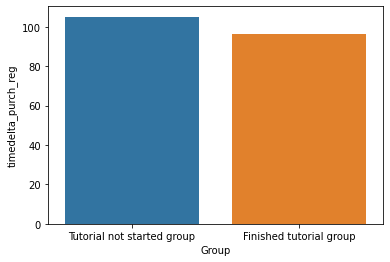

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_purch_reg', data = means)

Разница во времени между **выбором уровня и покупкой** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_purch_lvl'>

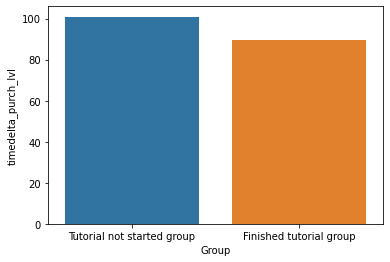

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_purch_lvl', data = means)

Разница во времени между **выбором пакетов игры и покупкой** для 2-ух групп

<AxesSubplot:xlabel='Group', ylabel='timedelta_purch_pack'>

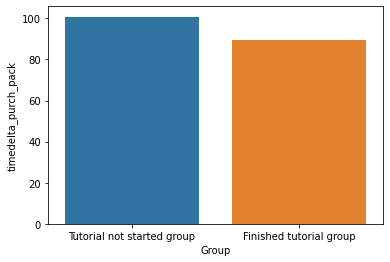

In [ ]:
sns.barplot(x = 'Group', y = 'timedelta_purch_pack', data = means)

## Выводы по гипотезе №1
### Гипотеза №1 подтвердилась. Время прохождения различных этапов для разных групп отличается.

#### Разница во времени больше у группы пользователей, которые прошли, если это касается разницы между регистрацией и выбором уровня и регистрации и выбором пакетов игры. 

#### Разница во времени между выбором уровня и выбором пакетов у обеих групп примерно одинаковая. 

#### Однако картина меняется относительно этапа покупки: разницы во времени, касающиеся этого этапа, больше у группы пользователей, которые не начинали обучение.

## Гипотеза №2

### Успешное обучение влияет на оплату (без разницы, каким этапом оно шло).

In [ ]:
#создаем датафреймы, когда пользователь начал обучение и совершил покупку
df_users_cnt_tutorial_st = total_events.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_start').sum()).reset_index()
df_users_cnt_tutorial_fin = total_events.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_finish').sum()).reset_index()
df_users_cnt_purch = total_events.groupby(['user_id'])['event_type'].apply(lambda x: (x=='purchase').sum()).reset_index()

In [ ]:
#объединяем датафреймы
df_users_merged_1 = df_users_cnt_tutorial_st.merge(df_users_cnt_tutorial_fin, on = 'user_id',how='left')
df_users_tutorial_purch_merged = df_users_merged_1.merge(df_users_cnt_purch, on = 'user_id', how = 'left')
df_users_tutorial_purch_merged

,user_id,event_type_x,event_type_y,event_type
0,27832,0,0,0
1,27833,1,1,0
2,27834,1,1,0
3,27835,1,1,0
4,27836,2,1,0
...,...,...,...,...
19921,47753,1,1,0
19922,47754,0,0,0
19923,47755,1,1,0
19924,47756,1,1,0


In [ ]:
# Группа людей закончивших несколько раз обучение
tut_count = total_events[total_events.event_type == 'tutorial_finish'].user_id.value_counts()
tut_count.unique()
tut_count

35713    9
47108    9
29547    9
44276    9
39496    9
        ..
36959    1
46060    1
41057    1
39014    1
32768    1
Name: user_id, Length: 10250, dtype: int64

In [ ]:
# Переименовываем правильно столбцы
tut_count_df = tut_count.reset_index()
tut_count_df = tut_count_df.rename(columns = {'index':'user_id','user_id':'tut_count'})
tut_count_df

,user_id,tut_count
0,35713,9
1,47108,9
2,29547,9
3,44276,9
4,39496,9
...,...,...
10245,36959,1
10246,46060,1
10247,41057,1
10248,39014,1


In [ ]:
# Датасет с покупателями
purch = set(total_events[total_events.event_type == 'purchase'].user_id.unique())
# Датасет с покуп. и непокуп.
df3 = pd.DataFrame(index = ['purchase','no_purchase'])
for i in range(1,10):
    u = set(tut_count_df[tut_count_df.tut_count == i].user_id)
    np = u-purch
    p = u-np
    df3[str(i)] = [len(p),len(np)]
df3

,1,2,3,4,5,6,7,8,9
purchase,1143,182,44,19,19,15,15,6,4
no_purchase,6872,1139,301,159,98,86,82,48,18


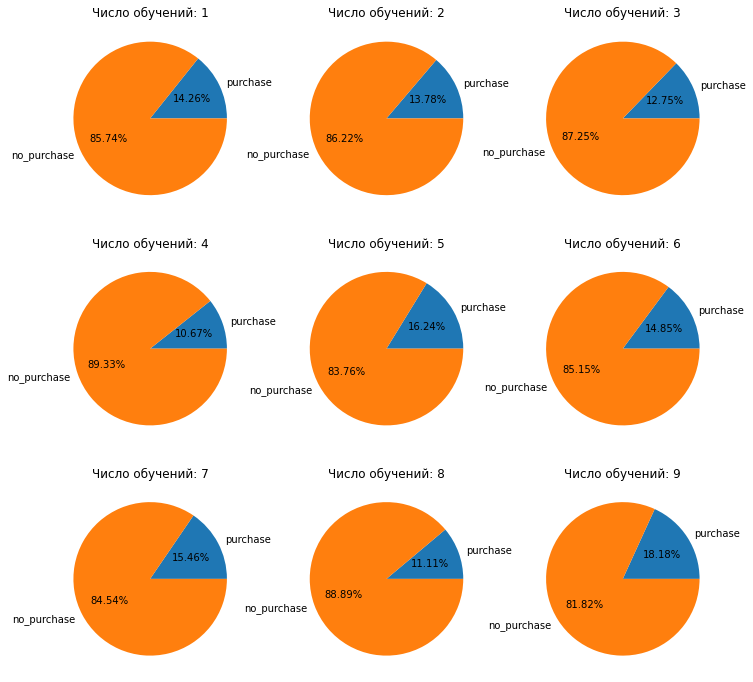

In [ ]:
# Возвращает axs3 в виде двумерного массива
f3, axs3 = plt.subplots(3, 3, figsize = (12, 12))
for i in range(9):
    # Получаем по i 2 координаты (j и k)
    j = i // 3 
    k = i - j*3
    # Пришлось заменить df3.plot.pie на ax3[j][k].pie(...), т.к. иначе вставка графика происходит не в ячейку, а за сеткой
    axs3[j][k].pie(x=df3[str(i+1)], labels=df3.index, autopct='%.2f%%')
    # Заголовок к каждому графику
    axs3[j][k].set_title(label=f"Число обучений: {str(i+1)}")
plt.show()

## Выводы по гипотезе №2
### Гипотеза №2 подтвердилась. Успешное прохождение обучения влияет на вероятность оплаты.

#### Процент оплат снижается с увеличением числа прохождения оплат до 4 (с 14,26% до 10,67%). На 5 разе значительно возрастает(16,24%), но после снова снижается вплоть до 8 раза. На 9 разе прохождения замечено сильное увеличение процента оплат (18,18%) по сравнению со всеми диаграммами.

## Дополнительная задача

### Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

In [ ]:
# Датафрейм, содержащий пользователей, подходящих под категорию
pivot = total_events.pivot_table(values = ['start_time'], index = ['user_id'], columns = ['event_type'], aggfunc = 'max')
pivot.columns=list(map('_'.join,pivot))
pivot = pivot.reset_index()
pivot['timedelta_tut_lvl'] = pivot['start_time_tutorial_start'] - pivot['start_time_level_choice']
pivot_repeat = pivot[pivot.timedelta_tut_lvl > '00:00:00']
pivot_repeat

,user_id,start_time_level_choice,start_time_pack_choice,start_time_purchase,start_time_registration,start_time_tutorial_finish,start_time_tutorial_start,timedelta_tut_lvl
10,27842,2018-01-02 08:46:03,NaT,NaT,2018-01-01 23:18:46,2018-01-02 18:11:26,2018-01-02 18:08:01,0 days 09:21:58
13,27845,2018-01-02 06:19:18,2018-01-02 06:25:12,2018-01-03 18:53:43,2018-01-02 01:35:56,2018-01-02 07:09:50,2018-01-02 07:08:00,0 days 00:48:42
20,27852,2018-01-02 18:39:44,NaT,NaT,2018-01-02 15:10:51,2018-01-02 20:38:04,2018-01-02 20:34:31,0 days 01:54:47
30,27862,2018-01-03 04:19:32,NaT,NaT,2018-01-03 00:58:05,2018-01-03 18:13:07,2018-01-03 18:10:28,0 days 13:50:56
44,27876,2018-01-04 04:29:55,NaT,NaT,2018-01-03 23:26:04,2018-01-04 05:04:16,2018-01-04 05:02:37,0 days 00:32:42
...,...,...,...,...,...,...,...,...
19763,47595,2018-12-27 18:52:43,NaT,NaT,2018-12-27 14:07:05,2018-12-27 21:14:07,2018-12-27 21:06:47,0 days 02:14:04
19803,47635,2018-12-28 11:43:38,2018-12-28 11:46:11,2018-12-31 16:32:52,2018-12-28 07:34:06,2018-12-28 17:31:05,2018-12-28 17:28:42,0 days 05:45:04
19825,47657,2018-12-28 21:25:49,NaT,NaT,2018-12-28 15:45:10,2018-12-28 21:59:25,2018-12-28 21:53:06,0 days 00:27:17
19879,47711,2018-12-29 21:23:23,2018-12-29 21:28:47,NaT,2018-12-29 17:59:45,2018-12-29 22:55:12,2018-12-29 22:50:57,0 days 01:27:34


In [ ]:
repeat = set(pivot_repeat.user_id.unique())

pivot_lvl_ch = pivot[pivot.start_time_level_choice.notnull()]
lvl_ch = set(pivot_lvl_ch.user_id.unique())

In [ ]:
for_pie = pd.DataFrame(index = ['repeat_tut','all_lvl_ch'])
for_pie['num'] = [len(repeat),len(lvl_ch)]
for_pie

,num
repeat_tut,1386
all_lvl_ch,8342


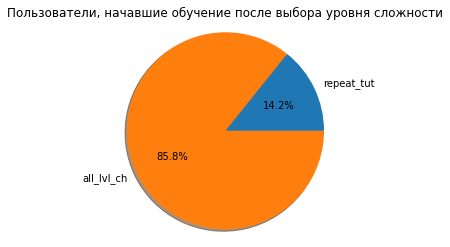

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(x = for_pie['num'], labels=for_pie.index, autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')
ax1.set_title(label = "Пользователи, начавшие обучение после выбора уровня сложности")
plt.show()

## Выводы к доп. задаче:
### 14% пользователей, выбравших уровень сложности, возвращаются к обучению. Данный факт говорит о том, что для некоторых пользователей работа с приложением всё-таки вызывает трудности. Возможно стоит сделать процесс обучения проще или же попробовать улучшить интерфейс игры.